In [1]:
import matplotlib.pyplot as plt
import scanpy as sc

import scvi
from scvi.external import SysVI
import anndata as ad
import pandas as pd

scvi.settings.seed = 0

/home/icb/zihe.zheng/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Seed set to 0


## process data

In [2]:
## process data
mouse = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/mouse_apoe/GSE225503_adapoe.h5ad')
human = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap_multi_region/hippocampus.h5ad')

# add microglia subtype for mouse
microglia_df = pd.read_csv("/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/mouse_apoe/microglia_cluster.csv")
merged = pd.merge(mouse.obs, microglia_df[['Unnamed: 0', 'mglia_ident']], left_index = True, right_on = 'Unnamed: 0', how = 'outer')
merged.index = mouse.obs.index
merged['fine_cluster'] = merged['mglia_ident'].fillna(merged['clust_id'])
merged.drop(columns = ['Unnamed: 0', 'mglia_ident'], inplace = True)
mouse.obs = merged

## subset for overapping genes between human and mouse
mouse_genes = list(mouse.var['features'])
mouse_genes = [item.upper() for item in mouse_genes]
mouse.var['upper_genes'] = mouse_genes

human_genes = set(human.var_names)

both_genes = human_genes.intersection(mouse_genes)
mouse = mouse[:, mouse.var['upper_genes'].isin(both_genes)]
human = human[:, human.var_names.isin(both_genes)]

In [3]:
## subset for microglia cells in both
human = human[human.obs['cell_type_high_resolution'].isin(['Mic P2RY12', 'Mic TPT1', 'Mic DUSP1', 'Mic MKI67'])]
mouse = mouse[mouse.obs['microglia'] == 1]

### normalize and select hvg

In [4]:
sc.pp.normalize_total(mouse, target_sum = 1e6)
sc.pp.log1p(mouse)
sc.pp.highly_variable_genes(mouse, subset = True, n_top_genes = 5000)

/home/icb/zihe.zheng/.local/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
sc.pp.normalize_total(human, target_sum = 1e6)
sc.pp.log1p(human)
sc.pp.highly_variable_genes(human, subset = True, n_top_genes = 5000)

/home/icb/zihe.zheng/.local/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [6]:
mouse

AnnData object with n_obs × n_vars = 24750 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'age', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'seurat_clusters', 'genotype', 'clust_id', 'microglia', 'subclust_id', 'fine_cluster'
    var: '_index', 'features', 'upper_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap'

In [7]:
human

AnnData object with n_obs × n_vars = 21878 × 5000
    obs: 'obsnames', 'lbl', 'U1', 'U2', 'barcode', 'rind', 'region', 'projid', 'is.doublet', 'col', 'tspcol', 'hcluster', 'hcelltype', 'hsubclass', 'major.celltype', 'minor.celltype', 'neuronal.layer', 'inh.subtype', 'neuronal.exttype', 'full.exttype', 'cell_type_high_resolution'
    var: 'varnames', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [8]:
mouse_hvg = list(mouse.var['upper_genes'])

human_hvg = set(human.var_names)

both_hvg = human_hvg.intersection(mouse_hvg)
mouse = mouse[:, mouse.var['upper_genes'].isin(both_hvg)]
human = human[:, human.var_names.isin(both_hvg)]

In [9]:
mouse

View of AnnData object with n_obs × n_vars = 24750 × 1872
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'age', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'seurat_clusters', 'genotype', 'clust_id', 'microglia', 'subclust_id', 'fine_cluster'
    var: '_index', 'features', 'upper_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap'

In [10]:
human

View of AnnData object with n_obs × n_vars = 21878 × 1872
    obs: 'obsnames', 'lbl', 'U1', 'U2', 'barcode', 'rind', 'region', 'projid', 'is.doublet', 'col', 'tspcol', 'hcluster', 'hcelltype', 'hsubclass', 'major.celltype', 'minor.celltype', 'neuronal.layer', 'inh.subtype', 'neuronal.exttype', 'full.exttype', 'cell_type_high_resolution'
    var: 'varnames', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

### set up batch key

In [11]:
mouse.obs['system'] = 'mouse'
human.obs['system'] = 'human'

mouse.obs['donor'] = 'mouse'
human.obs['donor'] = human.obs['projid']

/tmp/ipykernel_847390/2807885086.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mouse.obs['system'] = 'mouse'
/tmp/ipykernel_847390/2807885086.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  human.obs['system'] = 'human'


In [12]:
mouse.var_names = mouse.var.upper_genes

In [13]:
adata = ad.concat([mouse, human], join = 'outer', axis = 0)

In [14]:
adata

AnnData object with n_obs × n_vars = 46628 × 1872
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'age', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'seurat_clusters', 'genotype', 'clust_id', 'microglia', 'subclust_id', 'fine_cluster', 'system', 'donor', 'obsnames', 'lbl', 'U1', 'U2', 'barcode', 'rind', 'region', 'projid', 'is.doublet', 'col', 'tspcol', 'hcluster', 'hcelltype', 'hsubclass', 'major.celltype', 'minor.celltype', 'neuronal.layer', 'inh.subtype', 'neuronal.exttype', 'full.exttype', 'cell_type_high_resolution'
    obsm: 'X_umap'

In [15]:
mouse.obs.clust_id.value_counts()

clust_id
Microglia    24750
Name: count, dtype: int64

In [16]:
human[human.obs['major.celltype']=='Mic/Immune'].obs['cell_type_high_resolution'].value_counts()

cell_type_high_resolution
Mic P2RY12    19806
Mic TPT1       1253
Mic DUSP1       768
Mic MKI67        51
Name: count, dtype: int64

In [17]:
human

AnnData object with n_obs × n_vars = 21878 × 1872
    obs: 'obsnames', 'lbl', 'U1', 'U2', 'barcode', 'rind', 'region', 'projid', 'is.doublet', 'col', 'tspcol', 'hcluster', 'hcelltype', 'hsubclass', 'major.celltype', 'minor.celltype', 'neuronal.layer', 'inh.subtype', 'neuronal.exttype', 'full.exttype', 'cell_type_high_resolution', 'system', 'donor'
    var: 'varnames', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [18]:
mouse

AnnData object with n_obs × n_vars = 24750 × 1872
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'age', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'seurat_clusters', 'genotype', 'clust_id', 'microglia', 'subclust_id', 'fine_cluster', 'system', 'donor'
    var: '_index', 'features', 'upper_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap'

## integration

In [58]:
# Setup adata for training
SysVI.setup_anndata(
    adata=adata,
    batch_key="system",
    # categorical_covariate_keys=["donor"],
)

In [59]:
# Example showing how to turn on embedding of all categorical covariates
model = SysVI(
    adata=adata,
    embed_categorical_covariates=True,
)

INFO     The model has been initialized                                                                            


In [60]:
# Initialise the model
# model = SysVI(adata=adata)
# Train
max_epochs = 200
model.train(
    max_epochs=max_epochs, check_val_every_n_epoch=1, plan_kwargs={"kl_weight": 5, "z_distance_cycle_weight": 2}
)

/home/icb/zihe.zheng/miniconda3/envs/sysvi/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/zihe.zheng/miniconda3/envs/sysvi/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/zihe.zheng/miniconda3/envs/sysvi/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/zihe.zheng/miniconda3/envs/sysvi/lib/pytho ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/icb/zihe.zheng/miniconda3/envs/sysvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connecto

Epoch 200/200: 100%|███████████| 200/200 [1:34:00<00:00, 20.95s/it, v_num=1, train_loss_step=378, train_loss_epoch=381]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████| 200/200 [1:34:00<00:00, 28.20s/it, v_num=1, train_loss_step=378, train_loss_epoch=381]


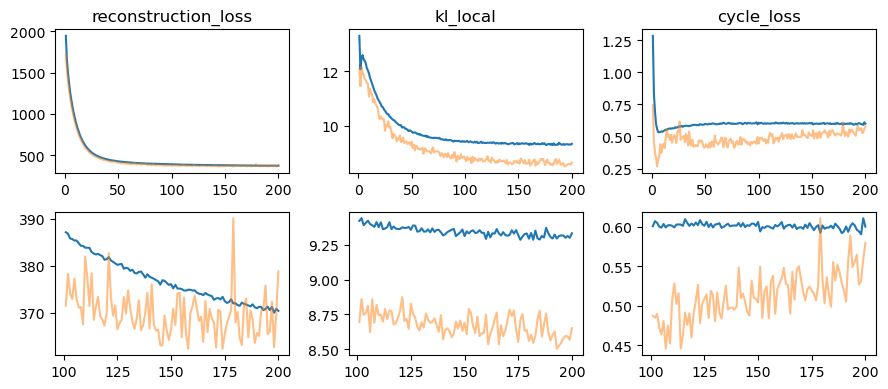

In [61]:
# Plot loses
# The plotting code below was specifically adapted to the above-specified model and its training
# If changing the model or training the plotting functions may need to be adapted accordingly

# Make detailed plot after N epochs
epochs_detail_plot = 100

# Losses to plot
losses = [
    "reconstruction_loss_train",
    "kl_local_train",
    "cycle_loss_train",
]
fig, axs = plt.subplots(2, len(losses), figsize=(len(losses) * 3, 4))
for ax_i, l_train in enumerate(losses):
    l_val = l_train.replace("_train", "_validation")
    l_name = l_train.replace("_train", "")
    # Change idx of epochs to start with 1
    l_val_values = model.trainer.logger.history[l_val].copy()
    l_val_values.index = l_val_values.index + 1
    l_train_values = model.trainer.logger.history[l_train].copy()
    l_train_values.index = l_train_values.index + 1
    for l_values, c, alpha, dp in [
        (l_train_values, "tab:blue", 1, epochs_detail_plot),
        (l_val_values, "tab:orange", 0.5, epochs_detail_plot),
    ]:
        axs[0, ax_i].plot(l_values.index, l_values.values.ravel(), c=c, alpha=alpha)
        axs[0, ax_i].set_title(l_name)
        axs[1, ax_i].plot(l_values.index[dp:], l_values.values.ravel()[dp:], c=c, alpha=alpha)

fig.tight_layout()

In [62]:
# Get embedding - save it into X of new AnnData
embed = model.get_latent_representation(adata=adata)
embed = sc.AnnData(embed, obs=adata.obs)
# Make system categorical for plotting below
embed.obs["system"] = embed.obs["system"]

In [63]:
# Compute UMAP
sc.pp.neighbors(embed, use_rep="X")
sc.tl.umap(embed)

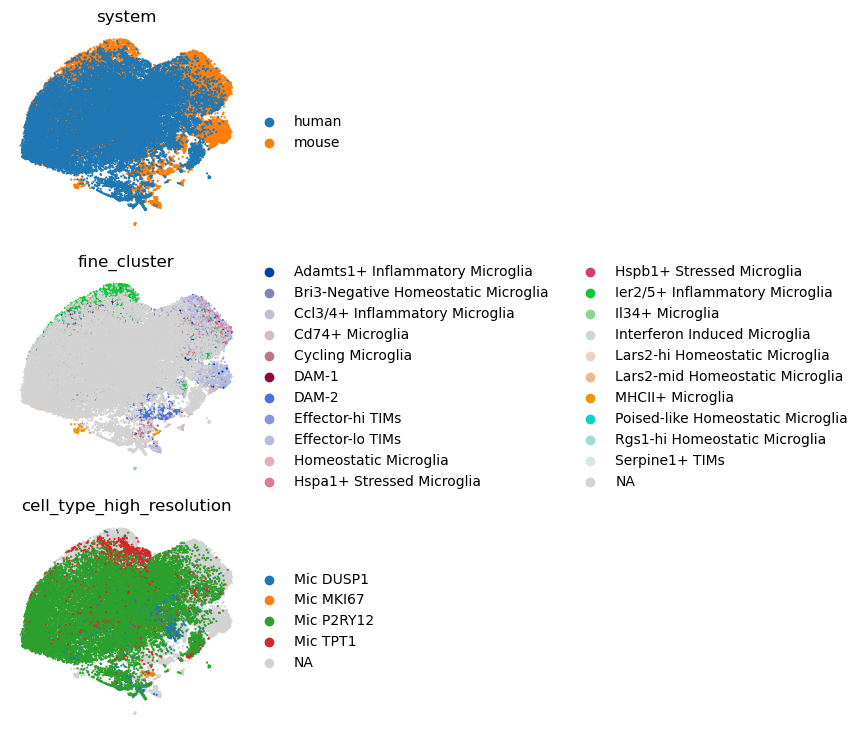

In [64]:

# Obs columns to color by
cols = ["system", "fine_cluster", 'cell_type_high_resolution']

# One plot per obs column used for coloring
fig, axs = plt.subplots(len(cols), 1, figsize=(3, 3 * len(cols)))
for col, ax in zip(cols, axs, strict=False):
    sc.pl.embedding(
        embed,
        "X_umap",
        color=col,
        s=10,
        ax=ax,
        show=False,
        sort_order=False,
        frameon=False,
    )